# Plotting Nonlinearity results

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
from scipy import stats

In [4]:
import seaborn as sns

In [5]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

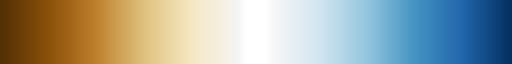

In [6]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [7]:
# plotting code
import matplotlib as m
from matplotlib.colors import BoundaryNorm as BM


def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE, alpha=0.9, lw=0.5)
    ax.set_global()
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax

def plot(x, y, z, titles, cmap, levels, cbar_label = 'Precip', pval = [], nrows=1, ncols=3, figsize=(12,4), ocean_mask_list = [0]):
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True, subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
    
    for i in range(len(z)):
        axlist[i].contourf(x, y, z[i], cmap = cmap, transform = ccrs.PlateCarree(central_longitude=180), levels=levels, extend='both')
        axlist[i].set_title(titles[i])
        if i in ocean_mask_list:
            axlist[i].add_feature(cfeature.OCEAN, color = 'lightgray', zorder=2)
        if pval != []:
            axlist[i].scatter(x[np.abs(pval) < 0.05], y[np.abs(pval) < 0.05], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        # axlist[i].set_title('IMD', fontdict={'fontsize':12})
        
    norm = BM(levels, 256, extend='both')
    fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = axlist, \
                orientation = 'horizontal', shrink=0.4, aspect = 20, pad = 0.05, label = cbar_label)

In [8]:
import os

In [9]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/proc/'))[1:]

In [10]:
model_list

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL',
 'obs',
 'rean']

## normal ensemble average (no weights)

### ann

In [11]:
def convert_to_da(arr, var_name):
    lat = np.arange(-90, 93, 3)
    lon = np.arange(-180, 183, 3)
    if len(np.shape(arr)) == 2:
        da = xr.DataArray(data=arr,
                         dims=["lat", "lon"],
                         coords=dict(lat=(["lat"], lat), lon=(["lon"], lon)),
                         name = var_name
                         )
        return da
    elif len(np.shape(arr)) == 3:
        model = np.arange(1, 33, 1)
        da = xr.DataArray(data=arr,
                         dims=["model", "lat", "lon"],
                         coords=dict(model=(["model"], model), lat=(["lat"], lat), lon=(["lon"], lon)),
                         name = var_name
                         )
        return da

In [12]:
def load(model_list, period = 'ann'):
    from sys import exit
    if period not in ['ann', 'djf', 'mam', 'jja', 'son']:
        print('ERROR : period not correct')
        exit(0)
    base_loc = '/scratch/ob22/as8561/data/proc/'
    generic_path = base_loc + 'ACCESS-CM2/None/'
    da_arr = []
    for file_name in os.listdir(generic_path):
        out_arr = []
        for model in model_list:
            try:
                path = base_loc + f'{model}/{period}/'
                out = np.load(path + file_name)
                out_arr.append(out)
            except FileNotFoundError:
                period = 'None'
                path = base_loc + f'{model}/{period}/'
                out = np.load(path + file_name)
                out_arr.append(out)
                period = 'ann'
        out_da = convert_to_da(out_arr, file_name[:-4])
        da_arr.append(out_da)
    return xr.merge(da_arr)

In [62]:
model_ann = load(model_list, period='ann')

In [63]:
model_ann

<xarray.Dataset>
Dimensions:  (model: 32, lat: 61, lon: 121)
Coordinates:
  * model    (model) int64 1 2 3 4 5 6 7 8 9 10 ... 24 25 26 27 28 29 30 31 32
  * lat      (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 168 171 174 177 180
Data variables: (12/15)
    pval     (model, lat, lon) float64 0.1552 0.142 0.1327 ... 0.4738 0.4725
    neut     (model, lat, lon) float64 0.003347 -0.003255 ... 0.05612 0.08696
    nina     (model, lat, lon) float64 0.03437 0.02652 ... 0.07922 0.06397
    enc      (model, lat, lon) float64 -0.08577 -0.1071 -0.1085 ... -1.59 -1.612
    lnc      (model, lat, lon) float64 0.03103 0.02977 ... 0.0231 -0.02299
    nonl_pc  (model, lat, lon) float64 0.3191 0.3609 0.2858 ... 0.0 0.0 0.0
    ...       ...
    ratio    (model, lat, lon) float64 -0.4687 -0.5648 -0.4002 ... 0.0 0.0 0.0
    clim     (model, lat, lon) float64 4.553 4.538 4.527 ... 19.22 19.2 19.19
    std      (model, lat, lon) float64 0.6266 0.6164 0.6099 ... 2.498 2.498
    nino     (model, lat, lon) float64 -0.08243 -0.1103 ... -1.534 -1.525
    lin_pc   (model, lat, lon) float64 0.6809 0.6391 0.7142 ... 0.0 0.0 0.0
    lin      (model, lat, lon) float64 -0.0584 -0.06841 -0.07751 ... 0.0 0.0 0.0

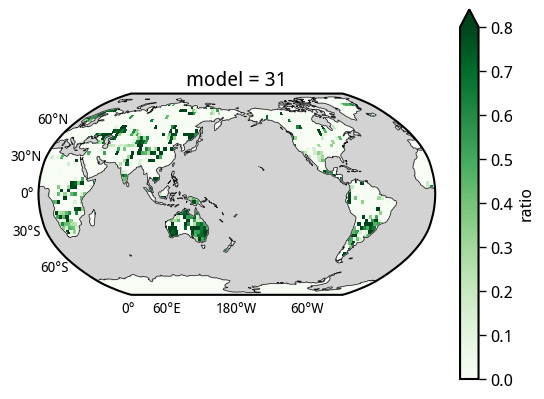

In [65]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
plot_background(ax)
(model_ann.ratio).isel(model = -2).plot(vmin=0, vmax=0.8, extend='max', cmap = 'Greens', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=1)

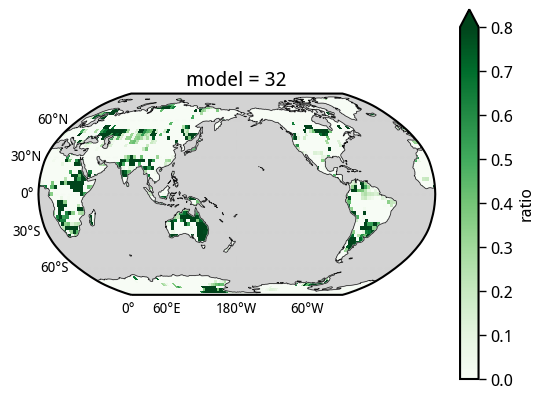

In [66]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
plot_background(ax)
(model_ann.ratio).isel(model = -1).plot(ax =ax, vmin=0, vmax=0.8, extend='max', cmap = 'Greens', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=1)

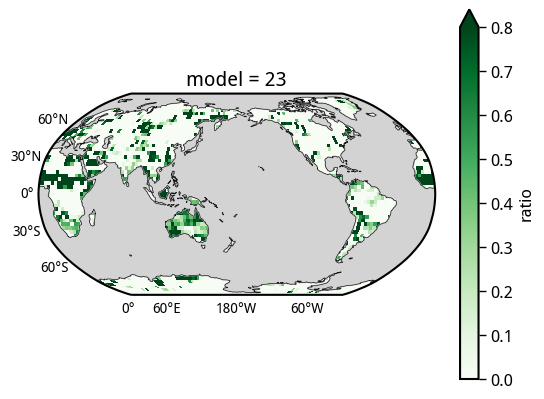

In [67]:
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
plot_background(ax)
(model_ann.ratio).isel(model = -10).plot(ax =ax, vmin=0, vmax=0.8, extend='max', cmap = 'Greens', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=1)

In [68]:
import regionmask

In [69]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(model_ann, wrap_lon=False, drop=False)

In [70]:
model_ann_masked = model_ann.where(mask.isel(region=0), other=0)

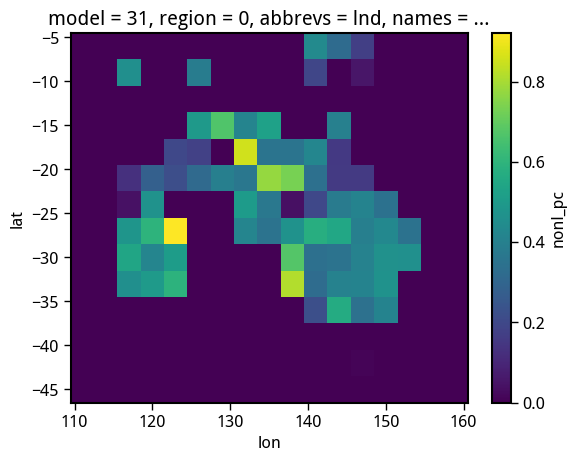

In [71]:
model_ann_masked.sel(lat = slice(-45,-5), lon = slice(110, 160)).nonl_pc.isel(model=-2).plot()

In [72]:
obs_ratio = (model_ann_masked.ratio).isel(model = -2).to_numpy().flatten()
rean_ratio = (model_ann_masked.ratio).isel(model = -1).to_numpy().flatten()
rean_ratio[rean_ratio < 0] = 0
rean_ratio[rean_ratio > 1] = 0
obs_ratio[obs_ratio < 0] = 0
obs_ratio[obs_ratio > 1] = 0

In [73]:
obs_nonl_pc = (model_ann_masked.nonl_pc*100).isel(model = -2).to_numpy().flatten()
rean_nonl_pc = (model_ann_masked.nonl_pc*100).isel(model = -1).to_numpy().flatten()
# obs_nonl[obs_nonl <= 0] = np.nan
# rean_nonl[rean_nonl <= 0] = np.nan

In [74]:
obs_nonl = (model_ann_masked.nonl).isel(model = -2).to_numpy().flatten()
rean_nonl = (model_ann_masked.nonl).isel(model = -1).to_numpy().flatten()
obs_nonl[obs_nonl == np.nan] = 0
rean_nonl[rean_nonl == np.nan] = 0

In [75]:
stats.pearsonr(obs_ratio, rean_ratio)

PearsonRResult(statistic=0.22111914649116904, pvalue=1.98752631010835e-82)

In [76]:
stats.pearsonr(obs_nonl_pc, rean_nonl_pc)

PearsonRResult(statistic=0.3574555565212647, pvalue=2.3132970705975453e-221)

In [77]:
stats.pearsonr(obs_nonl, rean_nonl)

PearsonRResult(statistic=0.26592782088709677, pvalue=1.0552762234513932e-119)

In [109]:
def gen_df_stat(da, model_list):
    import pandas as pd
    obs_nonl_pc = (da.nonl_pc*100).isel(model=-2).to_numpy().flatten()
    obs_ratio = (da.ratio).isel(model=-2).to_numpy().flatten()
    obs_nonl = (da.nonl).isel(model=-2)
    eno = ((da.enc).isel(model = -2))
    lno = ((da.lnc).isel(model = -2))
    nonlo = ((da.nonl).isel(model = -2))
    ratio_cc = []
    ratio_std = []
    ratio_mean = []
    ratio_bias = []
    ratio_rmse = []
    nonl_pc_cc = []
    nonl_pc_std = []
    nonl_pc_mean = []
    nonl_pc_bias = []
    nonl_pc_rmse = []
    nonl_cc = []
    nonl_bias = []
    pattern_bias = []
    pattern_nino = []
    pattern_nina = []
    # nonl_mean = []
    # nonl_bias = []
    # nonl_rmse = []
    for i in range(32):
        # calculating vals and corr for pc and ratio
        nonl_pc = (da.nonl_pc*100).isel(model=i).to_numpy().flatten()
        npcc = stats.pearsonr(obs_nonl_pc, nonl_pc).statistic
        nonl_pc[nonl_pc <= 0] = np.nan
        ratio = (da.ratio).isel(model=i).to_numpy().flatten()
        ratio[ratio < 0] = 0
        ratio[ratio > 1] = 0
        obs_ratio[obs_ratio < 0] = 0
        obs_ratio[obs_ratio > 1] = 0
        rcc = stats.pearsonr(obs_ratio, ratio).statistic
        ## calculating the pattern cc, mean, bias and rmse for the actual nonl pattern
        # mmean = ((da.nonl).isel(model=i)).mean()
        # mbias = ((da.nonl).isel(model=i) - obs_nonl).mean()
        # mrmse = np.sqrt(np.square((da.nonl).isel(model=i) - obs_nonl).mean())
        oo = obs_nonl.to_numpy().flatten()
        mm = ((da.nonl).isel(model = i)).to_numpy().flatten()
        oo[oo == np.nan] = 0
        mm[mm == np.nan] = 0
        mcc = stats.pearsonr(oo, mm).statistic
        # temporary
        enm = ((da.enc).isel(model = i) - eno)#.mean()
        lnm = ((da.lnc).isel(model = i) - lno)#.mean()
        nonlm = ((da.nonl).isel(model = i) - nonlo)
        # append the values
        ratio_cc.append(rcc)
        ratio_std.append(np.nanstd(ratio))
        ratio_mean.append(np.nanmean(ratio))
        nonl_pc_cc.append(npcc)
        nonl_pc_std.append(np.nanstd(nonl_pc))
        nonl_pc_mean.append(np.nanmean(nonl_pc))
        nonl_cc.append(mcc)
        nonl_bias.append(float(nonlm.mean()))
        pattern_bias.append(float(((enm + lnm)/2).mean()))
        pattern_nino.append(float(enm.mean()))
        pattern_nina.append(float(lnm.mean()))
        # nonl_bias.append(float(mbias))
        # nonl_rmse.append(float(mrmse))
        # nonl_mean.append(float(mmean))
    df_dict = dict(models = model_list, ratio_cc = ratio_cc, ratio_std = ratio_std, ratio_mean = ratio_mean, \
                   nonl_pc_cc = nonl_pc_cc, nonl_pc_std = nonl_pc_std, nonl_pc_mean = nonl_pc_mean, nonl_cc = nonl_cc, \
                   nonl_bias=nonl_bias, pattern_bias = pattern_bias, pattern_nino=pattern_nino, pattern_nina=pattern_nina)
                   # nonl_bias = nonl_bias, nonl_rmse = nonl_rmse, nonl_mean = nonl_mean)
    df = pd.DataFrame(df_dict)
    return df

In [110]:
df = gen_df_stat(model_ann_masked, model_list)

In [111]:
df_aus = gen_df_stat(model_ann_masked.sel(lat=slice(-45,-5), lon=slice(110, 160)), model_list)

In [112]:
df_aus.head()

,models,ratio_cc,ratio_std,ratio_mean,nonl_pc_cc,nonl_pc_std,nonl_pc_mean,nonl_cc,nonl_bias,pattern_bias,pattern_nino,pattern_nina
0,ACCESS-CM2,0.312453,0.030783,0.004725,0.513855,24.484247,41.819135,-0.163349,-1.722307,-1.780403,-1.919165,-1.641641
1,ACCESS-ESM1-5,0.262710,0.157635,0.068601,0.693592,12.615650,20.842122,-0.066232,-0.459578,-0.544941,-2.276031,1.186149
2,AWI-CM-1-1-MR,0.184575,0.110819,0.036226,0.546321,15.333056,22.111182,-0.267919,-1.043347,-1.151689,-2.776374,0.472996
3,CESM2,0.501785,0.226910,0.124981,0.588234,16.697479,30.370142,0.729773,1.034190,0.942084,-2.431626,4.315795
4,CESM2-WACCM,0.319328,0.119487,0.045792,0.482874,11.866506,17.329040,0.259921,-0.731368,-0.905809,-4.035410,2.223793


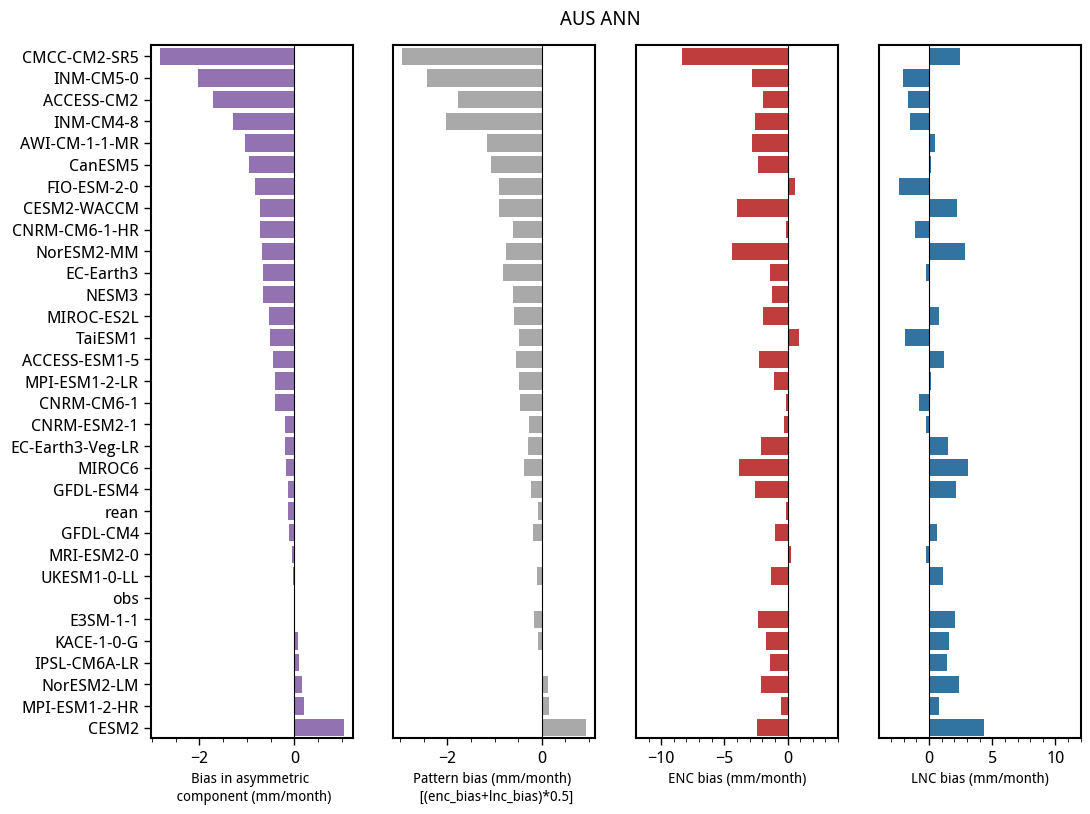

In [249]:
fig = plt.figure(figsize=(12,9))

plt.subplot(141)
sns.barplot(data=df_aus.sort_values('nonl_bias')[:], x = 'nonl_bias', y='models', color='tab:purple')
plt.yticks(fontsize=12)
plt.ylabel('')
plt.xlabel('Bias in asymmetric \n component (mm/month)', fontsize=10)
plt.axvline(0, color='k', lw=0.8)
plt.minorticks_on()
plt.gca().tick_params(axis='y', which='minor', left=False)
# plt.xlim(-3, 2.2)

plt.subplot(142)
sns.barplot(data=df_aus.sort_values('nonl_bias')[:], x = 'pattern_bias', y='models', color='darkgray')
plt.yticks([])
plt.ylabel('')
plt.xlabel('Pattern bias (mm/month) \n [(enc_bias+lnc_bias)*0.5]', fontsize=10)
plt.axvline(0, color='k', lw=0.8)
plt.minorticks_on()
plt.gca().tick_params(axis='y', which='minor', left=False)

plt.subplot(143)
sns.barplot(data=df_aus.sort_values('nonl_bias')[:], x = 'pattern_nino', y='models', color='tab:red')
plt.yticks([])
plt.ylabel('')
plt.xlabel('ENC bias (mm/month)', fontsize=10)
plt.axvline(0, color='k', lw=0.8)
plt.xlim(-12, 4)
plt.minorticks_on()
plt.gca().tick_params(axis='y', which='minor', left=False)

plt.subplot(144)
sns.barplot(data=df_aus.sort_values('nonl_bias')[:], x = 'pattern_nina', y='models', color='tab:blue')
plt.yticks([])
plt.ylabel('')
plt.xlabel('LNC bias (mm/month)', fontsize=10)
plt.axvline(0, color='k', lw=0.8)
plt.xlim(-4, 12)
plt.suptitle('AUS ANN', y=0.92, fontsize=14)
plt.minorticks_on()
plt.gca().tick_params(axis='y', which='minor', left=False)

plt.savefig('./PhD/prelim_tasks/images/perf/nonl_bias_cause_aus.png', dpi=300, bbox_inches='tight')

In [232]:
ww = (1/(np.abs(df_aus['pattern_bias'][:-2].to_numpy())**(1/2)))
nww = ww/ww.sum()

In [260]:
wgts = xr.DataArray(data=nww, dims=['model'], coords=dict(models = (["model"], model_djf.isel(model=slice(0,30)).model.to_numpy())))

In [270]:
model_djf_wgt = model_djf.isel(model = slice(0,30)).mean('model')

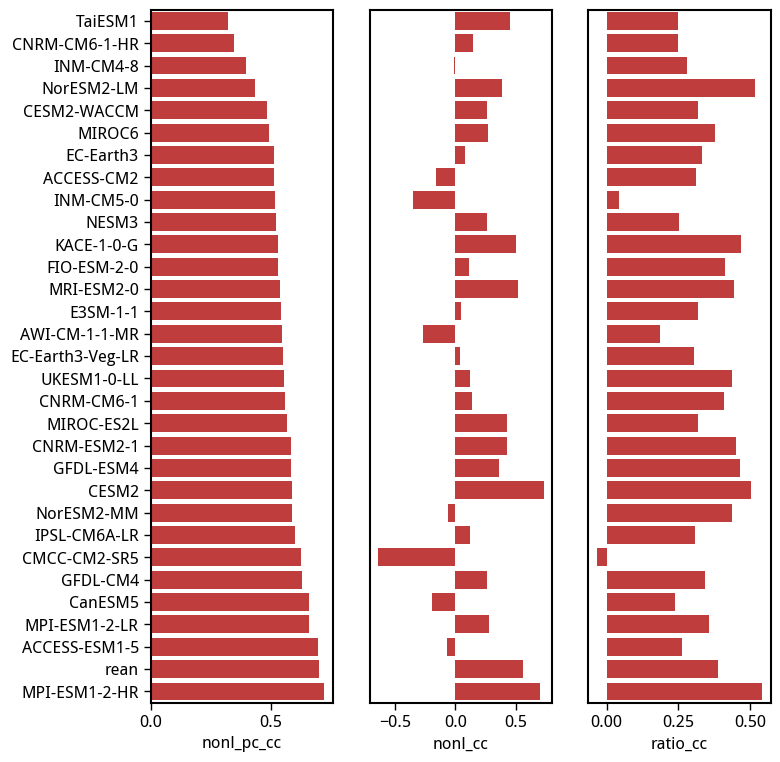

In [114]:
fig = plt.figure(figsize=(8,9))

plt.subplot(131)
sns.barplot(data=df_aus.sort_values('nonl_pc_cc')[:-1], x = 'nonl_pc_cc', y='models', color='tab:red')
# plt.xlim(-0.3, 0.4)
plt.yticks(fontsize=12)
plt.ylabel('')

plt.subplot(132)
sns.barplot(data=df_aus.sort_values('nonl_pc_cc')[:-1], x = 'nonl_cc', y='models', color='tab:red')
plt.yticks([])
plt.ylabel('')
# plt.xlim(-0.3, 0.4)

plt.subplot(133)
sns.barplot(data=df_aus.sort_values('nonl_pc_cc')[:-1], x = 'ratio_cc', y='models', color='tab:red')
plt.yticks([])
plt.ylabel('')
# plt.xlim(-0.3, 0.4)


plt.savefig('./PhD/prelim_tasks/images/perf/perf_cc_aus.png', dpi=300, bbox_inches='tight')

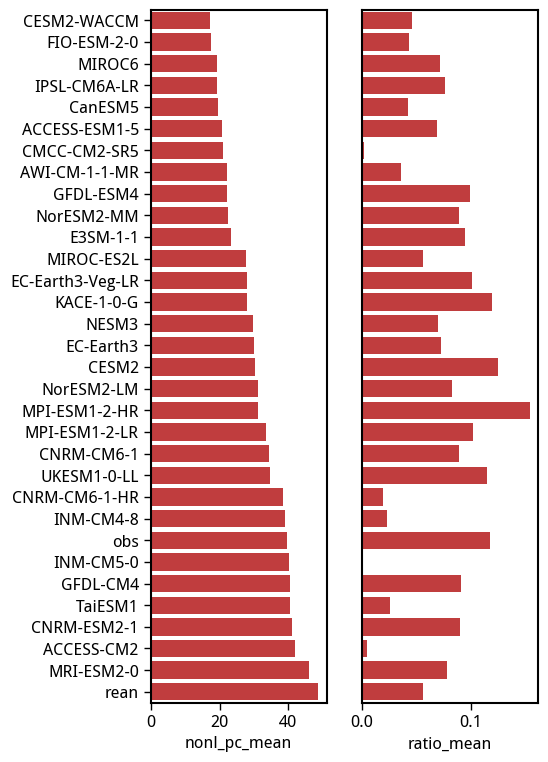

In [115]:
fig = plt.figure(figsize=(5,9))

plt.subplot(121)
sns.barplot(data=df_aus.sort_values('nonl_pc_mean')[:], x = 'nonl_pc_mean', y='models', color='tab:red')
# plt.xlim(-0.3, 0.4)
plt.yticks(fontsize=12)
plt.ylabel('')

plt.subplot(122)
sns.barplot(data=df_aus.sort_values('nonl_pc_mean')[:], x = 'ratio_mean', y='models', color='tab:red')
plt.yticks([])
plt.ylabel('')
# plt.xlim(-0.3, 0.4)


plt.savefig('./PhD/prelim_tasks/images/perf_mean_aus.png', dpi=300, bbox_inches='tight')

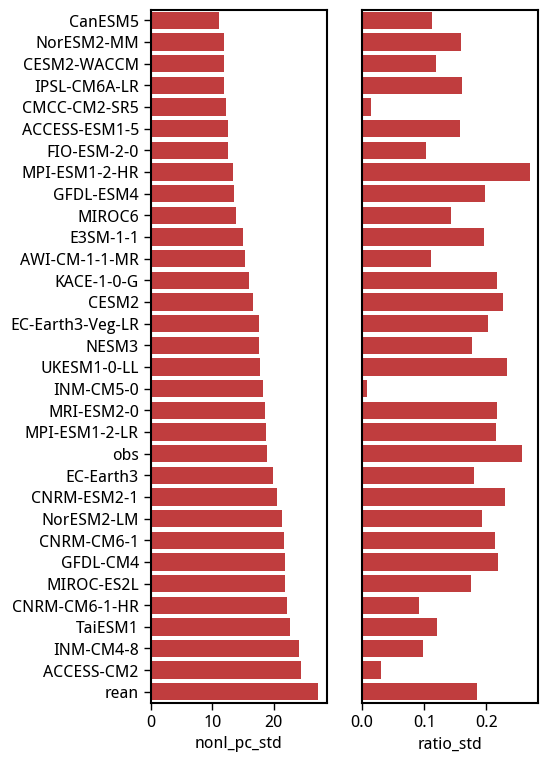

In [116]:
fig = plt.figure(figsize=(5,9))

plt.subplot(121)
sns.barplot(data=df_aus.sort_values('nonl_pc_std')[:], x = 'nonl_pc_std', y='models', color='tab:red')
# plt.xlim(-0.3, 0.4)
plt.yticks(fontsize=12)
plt.ylabel('')

plt.subplot(122)
sns.barplot(data=df_aus.sort_values('nonl_pc_std')[:], x = 'ratio_std', y='models', color='tab:red')
plt.yticks([])
plt.ylabel('')
# plt.xlim(-0.3, 0.4)


plt.savefig('./PhD/prelim_tasks/images/perf_std_glob.png', dpi=300, bbox_inches='tight')

<GeoAxesSubplot:>

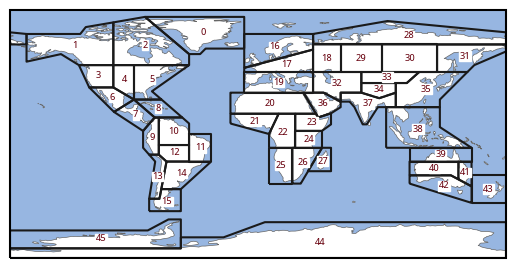

In [129]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))
regionmask.defined_regions.ar6.land.plot(text_kws=text_kws, add_ocean=True)

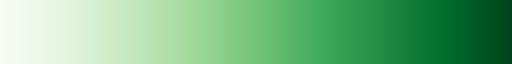

In [207]:
vals = np.linspace(0, 1, 46)

min_val, max_val = min(vals), max(vals)

# use the coolwarm colormap that is built-in, and goes from blue to red
cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
colors = cmap(vals)
cmap

In [208]:
len(colors)

46

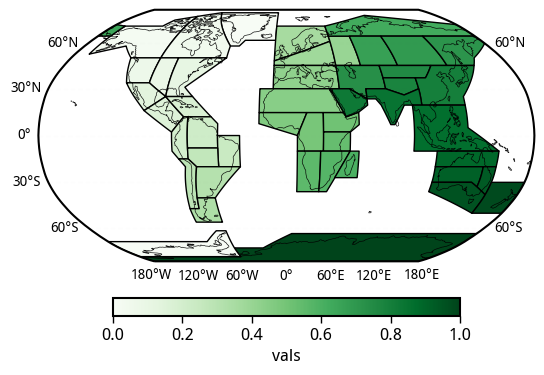

In [243]:
ax = plt.axes(projection = ccrs.Robinson())
pg = regionmask.defined_regions.ar6.land.polygons
cf = ax.add_geometries(pg, crs=ccrs.PlateCarree(), facecolor=list(colors), edgecolor='k', alpha=1.0)
# fig.colorbar(cf, cmap=cmap, norm=norm, ticks = sorted(vals), orientation='horizontal')
# cb.set_label('vals')
# ax.tick_params(axis='x', rotation=90)
plot_background(ax)
fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, \
            orientation = 'horizontal', shrink=0.7, aspect = 20, pad = 0.10, label = 'vals')

In [1]:
import climtas

## OLD and weighting methods

In [31]:
mme_nino = model_ann['nino_change'].mean('model')

In [32]:
mme_nina = model_ann['nina_change'].mean('model')

In [20]:
def get_significance_mask1d(x):
    sign = len(x[x <= 0.05])
    return (sign/30)

def get_significance_mask(da, dim):
    return xr.apply_ufunc(get_significance_mask1d, da, input_core_dims=[[dim]], vectorize=True, dask='parallelized')

In [33]:
mme_pval_nino = get_significance_mask(model_ann['pvalue_nino'], 'model')
mme_pval_nina = get_significance_mask(model_ann['pvalue_nina'], 'model')

In [34]:
mme_nonl = model_ann['nonlinearity'].mean('model')#(mme_nino + mme_nina)/2

In [62]:
obs_nonl = (obs_nino + obs_nina)/2
rean_nonl = (rean_nino + rean_nina)/2

In [35]:
x, y = np.meshgrid(np.arange(-180, 183, 3), np.arange(-90, 93, 3))

In [64]:
plot_list = [obs_nonl, rean_nonl, mme_nonl]

In [65]:
titles = ['OBS ANN', 'REAN ANN', 'MME ANN']

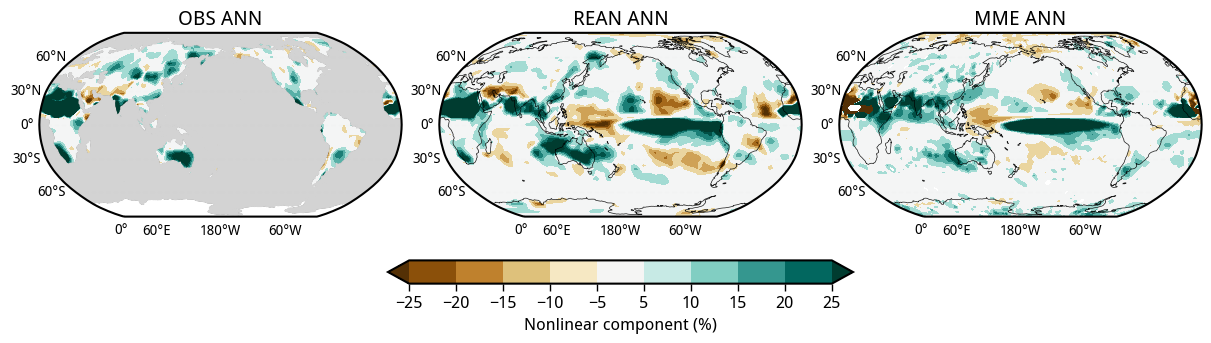

In [66]:
plot(x, y, plot_list, titles, cmap='BrBG', levels = [-25, -20, -15, -10, -5, 5, 10, 15, 20, 25], cbar_label='Nonlinear component (%)', nrows=1, ncols=3, figsize=(12,5))
# plt.savefig('./PhD/prelim_tasks/images/nonl_no_weights.png', dpi=300, bbox_inches='tight')

In [89]:
def calc_nonl_season(model_list, season):
    model_season = load_models(model_list, period=season)
    mme_nino = model_season['nino_change'].mean('model')
    mme_nina = model_season['nina_change'].mean('model')
    mme_nonl = (mme_nino + mme_nina)/2
    return mme_nonl

In [90]:
def calc_nonl_season2(val, season):
    val_nino = np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nino_change.npy')
    val_nina = np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nina_change.npy')
    # nonl = np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nonlinearity.npy')
    nonl = (val_nino + val_nina)/2
    return nonl

In [91]:
mme_nonl_djf = calc_nonl_season(model_list, season='djf')
mme_nonl_mam = calc_nonl_season(model_list, season='mam')
mme_nonl_jja = calc_nonl_season(model_list, season='jja')
mme_nonl_son = calc_nonl_season(model_list, season='son')

In [92]:
obs_nonl_djf = calc_nonl_season2('obs', season='djf')
obs_nonl_mam = calc_nonl_season2('obs', season='mam')
obs_nonl_jja = calc_nonl_season2('obs', season='jja')
obs_nonl_son = calc_nonl_season2('obs', season='son')

In [93]:
rean_nonl_djf = calc_nonl_season2('rean', season='djf')
rean_nonl_mam = calc_nonl_season2('rean', season='mam')
rean_nonl_jja = calc_nonl_season2('rean', season='jja')
rean_nonl_son = calc_nonl_season2('rean', season='son')

In [95]:
plot_list = [obs_nonl_djf, rean_nonl_djf, mme_nonl_djf,
             obs_nonl_mam, rean_nonl_mam, mme_nonl_mam,
             obs_nonl_jja, rean_nonl_jja, mme_nonl_jja,
             obs_nonl_son, rean_nonl_son, mme_nonl_son]

In [96]:
titles = ['OBS DJF', 'REAN DJF', 'MME DJF',
          'OBS MAM', 'REAN MAM', 'MME MAM',
          'OBS JJA', 'REAN JJA', 'MME JJA',
          'OBS SON', 'REAN SON', 'MME SON',]

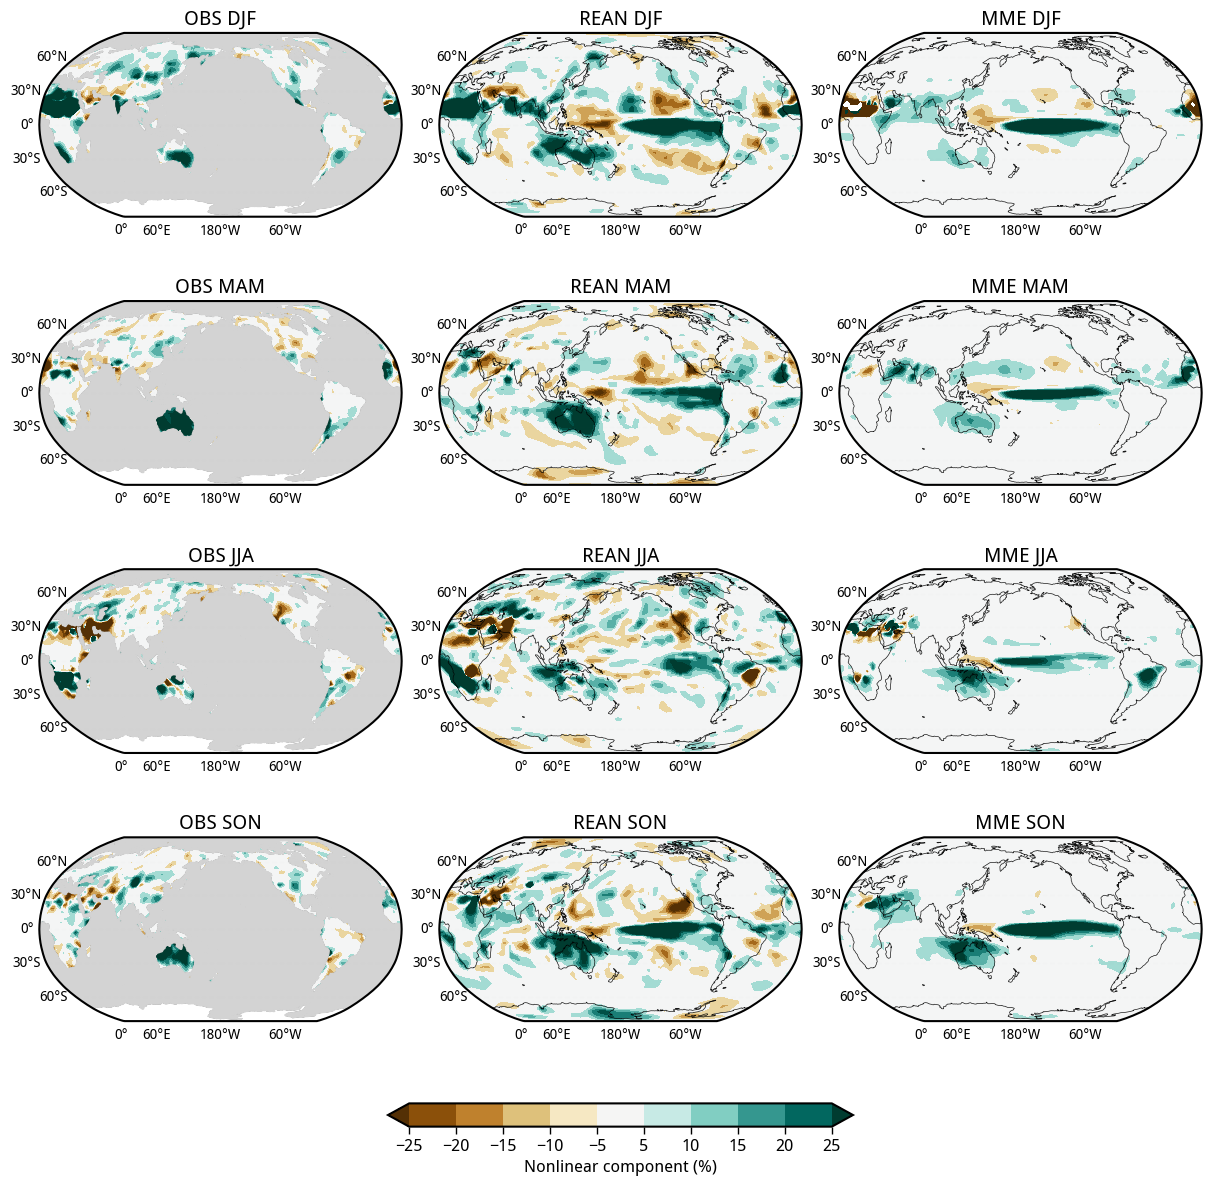

In [97]:
plot(x, y, plot_list, titles, cmap='BrBG', levels = [-25, -20, -15, -10, -5, 5, 10, 15, 20, 25], cbar_label='Nonlinear component (%)', nrows=4, ncols=3, figsize=(12,12), ocean_mask_list=[0, 3, 6, 9])
plt.savefig('./PhD/prelim_tasks/images/nonl_no_weights_seasonal.png', dpi=300, bbox_inches='tight')

### weighted average (method 1: RBW)

https://doi.org/10.1016/j.atmosres.2022.106334

#### ann

In [49]:
import seaborn as sns

In [50]:
def get_stats(model, obs):
    rmse_arr = np.empty((30))
    mae_arr = np.empty((30))
    corr_arr = np.empty((30))
    sigma_arr = np.empty((30))
    taylor_arr = np.empty((30))
    weights = np.cos(np.deg2rad(obs.lat))
    weights.name = 'weights'
    for i in range(30):
        rmse = np.sqrt((np.square(model[i] - obs)).weighted(weights).mean(('lat', 'lon')))
        mae = (np.abs(model[i] - obs)).weighted(weights).mean(('lat', 'lon'))
        obs_np = obs.to_numpy()
        model_np = np.nan_to_num(model[i].to_numpy()[obs_np != np.nan], nan=0.0)
        obs_np = np.nan_to_num(obs_np[obs_np != np.nan], nan=0.0)
        corr = float(stats.spearmanr(obs_np.flatten(), model_np.flatten()).statistic)
        sigma_m = np.std(model_np.flatten())
        sigma_o = np.std(obs_np.flatten())
        if (sigma_m/sigma_o) < 1:
            sigma = (sigma_m/sigma_o)
        else:
            sigma = (sigma_o/sigma_m)
        taylor = (4*np.square(1 + corr))/(np.square((1/sigma) + sigma)*np.square(1+0.999))
        rmse_arr[i] = rmse
        mae_arr[i] = mae
        corr_arr[i] = corr
        sigma_arr[i] = sigma
        taylor_arr[i] = taylor
    return rmse_arr, mae_arr, corr_arr, sigma_arr, taylor_arr

In [51]:
def get_ranks(df, var):
    rank_arr = np.empty((30))
    if var in ['corr', 'sigma', 'taylor']:
        rank_arr[np.array(df.sort_values(var, ascending=False).index)] = np.arange(1,31,1)
    else:
        rank_arr[np.array(df.sort_values(var, ascending=True).index)] = np.arange(1,31,1)
    return rank_arr

In [52]:
def get_cri_wgts(model, obs):
    rmse, mae, corr, sigma, taylor = get_stats(model, obs)
    data_dict = dict(models = model_list, rmse = rmse, mae = mae, corr = corr, sigma = sigma, taylor = taylor)
    model_stats = pd.DataFrame(data = data_dict)
    model_stats['rmse_rank'] = get_ranks(model_stats, 'rmse')
    model_stats['mae_rank'] = get_ranks(model_stats, 'mae')
    model_stats['corr_rank'] = get_ranks(model_stats, 'corr')
    model_stats['sigma_rank'] = get_ranks(model_stats, 'sigma')
    model_stats['taylor_rank'] = get_ranks(model_stats, 'taylor')
    model_stats['cri'] = 1 - ((1/(5*30)) *(model_stats['rmse_rank'].to_numpy() + model_stats['mae_rank'].to_numpy() + model_stats['corr_rank'].to_numpy() + model_stats['sigma_rank'].to_numpy() + model_stats['taylor_rank'].to_numpy()))
    cri = model_stats['cri']
    rr = 1/(cri/np.sum(cri))
    ww = rr/np.sum(rr)
    wgt = ww.to_xarray().rename(dict(index='model'))
    cri_wgt = model_stats['cri'].to_xarray().rename(dict(index='model'))
    
    return cri_wgt, ww

In [53]:
import pandas as pd

In [54]:
model_nino_wgt, ww_nino = get_cri_wgts(model_ann.nonlinearity, convert_to_da(obs_nonl, 'obs_nonl'))
# model_nina_wgt, ww_nina = get_cri_wgts(model_ann.nina_change, convert_to_da(obs_nina, 'obs_nina'))

In [42]:
wmme_nino = model_ann['nino_change'].weighted(model_nino_wgt).mean('model')
wmme_nina = model_ann['nina_change'].weighted(model_nina_wgt).mean('model')

In [55]:
wmme_nonl = model_ann['nonlinearity'].weighted(model_nino_wgt).mean('model') # (mme_nino + mme_nina)/2

In [56]:
plot_list = [obs_nonl, rean_nonl, mme_nonl, wmme_nonl, wmme_nonl - mme_nonl]

In [57]:
titles = ['OBS ANN', 'REAN ANN', 'MME ANN', 'MME wgt ANN', 'DIFF']

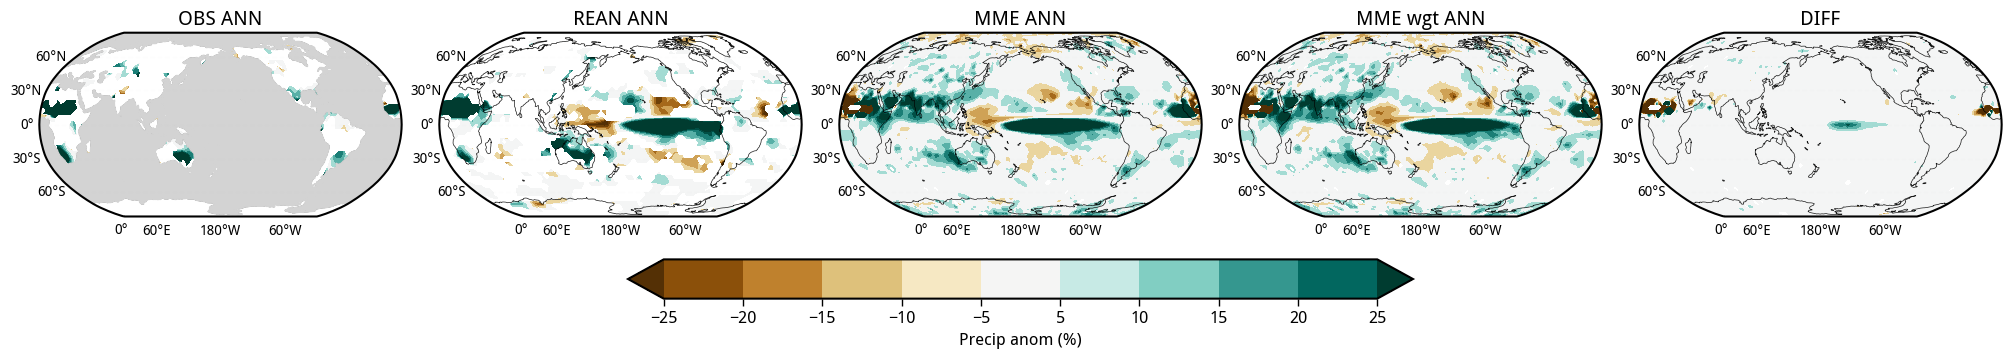

In [58]:
plot(x, y, plot_list, titles, cmap='BrBG', levels = [-25, -20, -15, -10, -5, 5, 10, 15, 20, 25], cbar_label='Precip anom (%)', nrows=1, ncols=5, figsize=(20,5))
# plt.savefig('./PhD/prelim_tasks/images/nino_wgted_diff2.png', dpi=300, bbox_inches='tight')

In [47]:
plot_list = [obs_nonl, rean_nonl, wmme_nonl]

In [48]:
titles = ['OBS ANN', 'REAN ANN', 'MME wgt ANN']

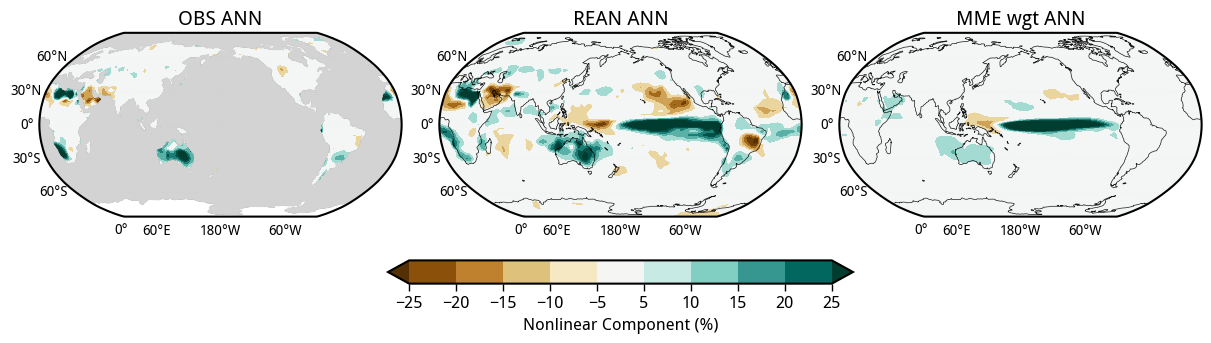

In [49]:
plot(x, y, plot_list, titles, cmap='BrBG', levels = [-25, -20, -15, -10, -5, 5, 10, 15, 20, 25], cbar_label='Nonlinear Component (%)', nrows=1, ncols=3, figsize=(12,5))
plt.savefig('./PhD/prelim_tasks/images/nonl_wgt.png', dpi=300, bbox_inches='tight')

#### seasons

In [98]:
def calc_nonl_season(model_list, season):
    model_season = load_models(model_list, period=season)
    en = model_season.nino_change
    ln = model_season.nina_change
    return en, ln

In [99]:
def calc_nonl_season2(val, season):
    val_nino = convert_to_da(np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nino_change.npy'), 'nino_change')
    val_nina = convert_to_da(np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nina_change.npy'), 'nina_change')
    # nonl = np.load(f'/scratch/ob22/as8561/data/results/{val}/{season}/nonlinearity.npy')
    nonl = (val_nino + val_nina)/2
    return val_nino, val_nina, nonl

In [100]:
obs_nino_djf, obs_nina_djf, obs_nonl_djf = calc_nonl_season2('obs', season='djf')
obs_nino_mam, obs_nina_mam, obs_nonl_mam = calc_nonl_season2('obs', season='mam')
obs_nino_jja, obs_nina_jja, obs_nonl_jja = calc_nonl_season2('obs', season='jja')
obs_nino_son, obs_nina_son, obs_nonl_son = calc_nonl_season2('obs', season='son')

In [101]:
rean_nino_djf, rean_nina_djf, rean_nonl_djf = calc_nonl_season2('rean', season='djf')
rean_nino_mam, rean_nina_mam, rean_nonl_mam = calc_nonl_season2('rean', season='mam')
rean_nino_jja, rean_nina_jja, rean_nonl_jja = calc_nonl_season2('rean', season='jja')
rean_nino_son, rean_nina_son, rean_nonl_son = calc_nonl_season2('rean', season='son')

In [102]:
model_nino_djf, model_nina_djf = calc_nonl_season(model_list, season='djf')
model_nino_mam, model_nina_mam = calc_nonl_season(model_list, season='mam')
model_nino_jja, model_nina_jja = calc_nonl_season(model_list, season='jja')
model_nino_son, model_nina_son = calc_nonl_season(model_list, season='son')

In [103]:
model_nino_wgt_djf, model_stats_nino_djf = get_cri_wgts(model_nino_djf, obs_nino_djf)
model_nina_wgt_djf, model_stats_nina_djf = get_cri_wgts(model_nina_djf, obs_nina_djf)

In [104]:
model_nino_wgt_mam, model_stats_nino_mam = get_cri_wgts(model_nino_mam, obs_nino_mam)
model_nina_wgt_mam, model_stats_nina_mam = get_cri_wgts(model_nina_mam, obs_nina_mam)

In [105]:
model_nino_wgt_jja, model_stats_nino_jja = get_cri_wgts(model_nino_jja, obs_nino_jja)
model_nina_wgt_jja, model_stats_nina_jja = get_cri_wgts(model_nina_jja, obs_nina_jja)

In [106]:
model_nino_wgt_son, model_stats_nino_son = get_cri_wgts(model_nino_son, obs_nino_son)
model_nina_wgt_son, model_stats_nina_son = get_cri_wgts(model_nina_son, obs_nina_son)

In [107]:
wmme_nino_djf = model_nino_djf.mean('model')
wmme_nino_mam = model_nino_mam.mean('model')
wmme_nino_jja = model_nino_jja.mean('model')
wmme_nino_son = model_nino_son.mean('model')

In [108]:
wmme_nina_djf = model_nina_djf.mean('model')
wmme_nina_mam = model_nina_mam.mean('model')
wmme_nina_jja = model_nina_jja.mean('model')
wmme_nina_son = model_nina_son.mean('model')

In [109]:
wmme_nonl_djf = (wmme_nino_djf + wmme_nina_djf)/2
wmme_nonl_mam = (wmme_nino_mam + wmme_nina_mam)/2
wmme_nonl_jja = (wmme_nino_jja + wmme_nina_jja)/2
wmme_nonl_son = (wmme_nino_son + wmme_nina_son)/2

In [110]:
plot_list = [obs_nonl_djf, rean_nonl_djf, wmme_nonl_djf,
             obs_nonl_mam, rean_nonl_mam, wmme_nonl_mam,
             obs_nonl_jja, rean_nonl_jja, wmme_nonl_jja,
             obs_nonl_son, rean_nonl_son, wmme_nonl_son]

In [111]:
titles = ['OBS DJF', 'REAN DJF', 'MME DJF',
          'OBS MAM', 'REAN MAM', 'MME MAM',
          'OBS JJA', 'REAN JJA', 'MME JJA',
          'OBS SON', 'REAN SON', 'MME SON',]

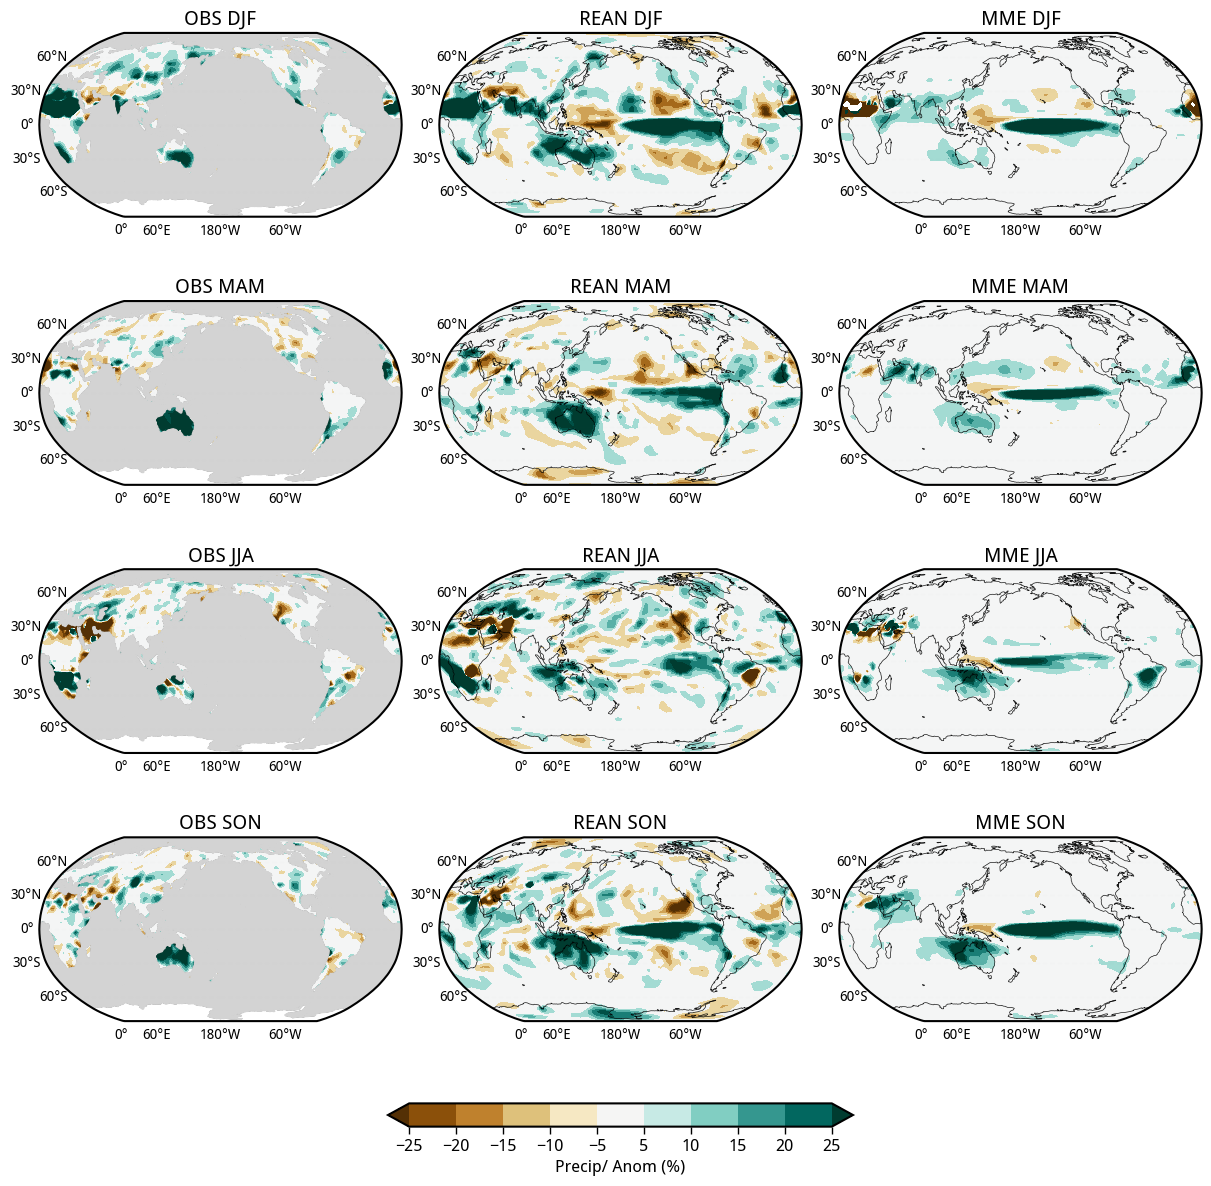

In [112]:
plot(x, y, plot_list, titles, cmap='BrBG', levels = [-25, -20, -15, -10, -5, 5, 10, 15, 20, 25], cbar_label='Precip/ Anom (%)', nrows=4, ncols=3, figsize=(12,12), ocean_mask_list=[0, 3, 6, 9])
plt.savefig('./PhD/prelim_tasks/images/nonl_wgted_seasonal.png', dpi=300, bbox_inches='tight')

In [694]:
cross_corr = []
stds = []
for i in range(30):
    res = stats.pearsonr(rean_nonl.flatten(), model[i].to_numpy().flatten())
    std = np.std(model_ann['nina_change'][i].to_numpy().flatten())
    cross_corr.append(res.statistic)
    stds.append(std)

In [697]:
stats.spearmanr(rean_nina.flatten(), wmme_nina.to_numpy().flatten())

SignificanceResult(statistic=0.7151757199732289, pvalue=0.0)

In [698]:
cross_corr, cross_pval

([0.7007379687821002,
  0.5166575688893005,
  0.6027123454160199,
  0.7593167543365893,
  0.7432577844207884,
  0.5562173833427752,
  0.5871339332509335,
  0.5291080994436972,
  0.6181597052046266,
  0.6419111584936441,
  0.6410948173280884,
  0.5720995163303462,
  0.6459723740154788,
  0.6677055859972595,
  0.6935607900709085,
  0.650241899037904,
  0.4110054895503922,
  0.36842535093711704,
  0.46173650444947534,
  0.7271201624227164,
  0.622823732180487,
  0.7238187790890946,
  0.6496747176869125,
  0.5339984682098241,
  0.6928192631079778,
  0.5073099107639039,
  0.6999547847349664,
  0.7341991196189432,
  0.5198333745843988,
  0.7114785071051678],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  7.074589500141475e-227,
  4.39619052356028e-124,
  1.8190291977122277e-252,
  4.3465775779226086e-206,
  2.059447628451435e-271,
  0.0,
  0.0,
  0.0,
  2.1365375177849914e-297,
  1.7990362031635616e-199,
  5.310774915073261e-74,
  1.1784433234640777e-96,
  1.2907027166838625e-152,
  0.0,
  2.44

In [8]:
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
        l1 , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        t1 = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        r1 = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_', alpha=0.5)
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        self.samplePoints = [l1]
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_sample(self,STD,r1,*args,**kwargs):
        l1,= self.ax.plot(np.arccos(r1), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l1)
        return l1

    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, r, l, markers, fname):
    fig=plt.figure(figsize=(17,8))
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
    for i in len(s):
        srlc = zip(s[i], r[i], l, markers)
        for j in srlc:
            dia.add_sample(j[0], j[1][0][1], label=j[2], marker=j[3], mec = 'tab:purple', mfc = 'none', mew=1.6)
    # for i in srlc2:
    #     dia.add_sample(i[0], i[1][0][1], label=i[2], marker=i[3], mec = 'tab:green', mfc = 'none', mew=1.6)
    # for i in srlc3:
    #     dia.add_sample(i[0], i[1][0][1], label=i[2], marker=i[3], mec = 'tab:red', mfc = 'none', mew=1.6)
    # for i in srlc4:
    #     dia.add_sample(i[0], i[1][0][1], label=i[2], marker=i[3], mec = 'tab:blue', mfc = 'none', mew=1.6)
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.7,0.3], ncols=2, frameon=False)
    # plt.savefig(fname, dpi=300, bbox_inches='tight')

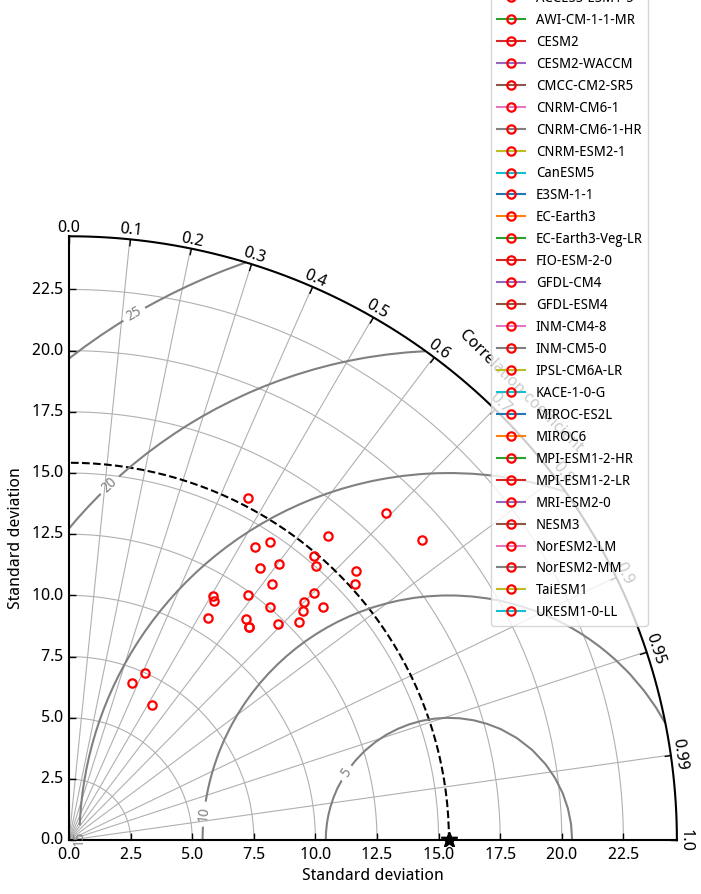

In [700]:
obsSTD = np.std(rean_nino.flatten())

s = stds
r = cross_corr

l = model_list

fname = 'TaylorDiagram.jpg'
srl(obsSTD, s, r, l, fname) 

### weighted average (method 2:  PI-weighting)

https://esd.copernicus.org/articles/13/321/2022/#section2